In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def get_stock_data(stock, start_date, end_date, interval, period):
        ticker = stock  
        yf.pdr_override()
        df = yf.download(tickers=stock, start=start_date, end=end_date, interval=interval, period=period)
        df.reset_index(inplace=True) 
        df['date'] = df['Date'].dt.date
      
        return df

#### Calculate the short moving average and long moving average

In [4]:
def ma_strategy(df,short_MA,long_MA):
    df['long_MA'] = df['Close'].rolling(int(long_MA)).mean()
    df['short_MA'] = df['Close'].rolling(int(short_MA)).mean()
    df['crosszero'] = np.where(df['short_MA'] < df['long_MA'], 1.0, 0.0)
    df['position'] = df['crosszero'].diff()
    df['position'].iloc[-1] = -1
    for i, row in df.iterrows():
        if df.loc[i,'position'] == 1 :
                buy_price = round(df.loc[i,'Close'],2)
                df.loc[i,'buy'] = buy_price
        if df.loc[i,'position'] == -1 :
                sell_price = round(df.loc[i,'Close'],2)
                df.loc[i,'sell'] = sell_price
    return df

#### Finding the buy and sell signals

In [5]:
def buy_sell_signals(df,stock,start_date,end_date):
    
        totalprofit = 0
        print('Stock: {}'.format(stock))
        print('Period: {} - {}'.format(start_date, end_date))
        print('-'*57)
        print('{:^7}{:^10}{:^15}{:^10}{:^15}'.format('S/N','Buy Date','Buy Price($)','Sell Date','Sell Price($)'))
        print('-'*57)

        for i, row in df.iterrows():
                        if df.loc[i,'position'] == 1 :
                                buy_price = round(df.loc[i,'buy'],2)
                                buydate = df.loc[i,'Date']
                        if df.loc[i,'position'] == -1 :
                                sell_price = round(df.loc[i,'sell'],2)
                                selldate  = df.loc[i,'Date']
                                profit = sell_price - buy_price
                                profit = round(profit,2)
                                totalprofit = totalprofit + profit
                                totalprofit = round(totalprofit,2)
                                print('{:^7}{}{:^15}{}{:^15}'.format(i,buydate,buy_price,selldate,sell_price))

        return df

#### Backtesting

In [6]:
def backtest(df,stock,start_date,end_date,initial_wealth) :
        # assumptions:
        initial_wealth = int(initial_wealth)
        profitloss = 0 
        position = 0
        total_profit = 0 
        qty = 0
        balance = initial_wealth
        buy_p = 0 # per share 
        total_buy_p = 0
        total_sell_p = 0 
        MA_wealth = initial_wealth # moving average wealth
        LT_wealth = initial_wealth # long-term wealth
        inital_sell = 0 
        df['position'].iloc[-1] = -1
                
    

        print('Stock: {}'.format(stock))
        print('Period: {} - {}'.format(start_date, end_date))
        print('Initial Wealth: {}'.format(initial_wealth))
        print('-'*100)
        print('{:^7}{:^15}{:^10}{:^15}{:^20}{:^20}{:^10}{:^20}{:^20}{:^20}{:^20}'.format('Sr. No','Buy Date','Buy Price($)','Sell Date','Sell Price($)','Investment($)','Qty','total_buy_p','total_sell_p','profitloss','MA_wealth'))
                                                                              
        print('-'*100)
        for i,row in df.iterrows():
            if position == 0:
                if df.loc[i,'position'] == 1:
                    buy_p =round( df.loc[i,'Close'],2)
                    buy_d = df.loc[i,'Date']
                    balance = balance + total_sell_p
                    qty = balance / buy_p
                    qty = math.trunc(qty)
                    total_buy_p = round(buy_p * qty,2)
                    balance = balance - total_buy_p 
                    position = 1       
                else:
                    price = df.loc[i,'Close'] 
                    if qty == 0 and MA_wealth == initial_wealth:
                        df.loc[i,'MA_wealth'] = balance
                    elif qty != 0 and MA_wealth != initial_wealth:
                        MA_wealth = sell_balance
                        df.loc[i,'MA_wealth'] = MA_wealth 
            elif position == 1:
                if df.loc[i,'position'] == -1:
                    sell_p = round(df.loc[i,'Close'],2)
                    sell_d = df.loc[i,'Date']
                  
                    total_sell_p = round(sell_p * qty,2)
                    profitloss = round(total_sell_p - total_buy_p,2)
                    total_profit = round(total_profit + profitloss,2)
                    sell_balance = round(balance + total_profit,2)
                    MA_wealth = round(balance + total_sell_p,2)
                    balance = round(balance,2)
                   
                    print('{:^7}{}{:^15}{}{:^15}{:^15}{:^15}{:^20}{:^20}{:^10}{:^10}'.format(i,buy_d,buy_p,sell_d,sell_p,MA_wealth,qty,total_buy_p,total_sell_p,profitloss,MA_wealth ))
                  
                    sell_balance = balance + total_sell_p
                    position = 0
                else:
                    price = df.loc[i,'Close'] 
                    stockprice = price * qty
                    MA_wealth = balance + stockprice
                    df.loc[i,'MA_wealth'] = MA_wealth
                    # print(MA_wealth)

            # long-term strategy           
        first_date = df['Date'].iloc[0]  
        initial_price = df['Close'].iloc[0]
        qty = LT_wealth/initial_price

        for i,row in df.iterrows():
            df.loc[i,'LT_wealth'] = df.loc[i,'Close'] * qty
                    
        last_date = df['Date'].iloc[-1]
        final_price = df['Close'].iloc[-1]
        
        LT_buy_p = initial_price * qty
        LT_sell_p = final_price * qty
        LT_profitloss = LT_sell_p - initial_wealth
        LT_wealth = initial_wealth + LT_profitloss
        MA_profitloss = MA_wealth - initial_wealth    
        MA_profitloss = round(MA_profitloss,2)
        LT_profitloss = round(LT_profitloss,2)


        print('-'*100)
        print('Short MA Profit/Loss: ${:,}, Long MA Profit/Loss: ${:,}'.format(MA_profitloss,LT_profitloss))
        print('')
        print('Short MA Final Wealth: ${:,.2f}, Long MA Final Wealth: ${:,.2f}'.format(MA_wealth,LT_wealth))
        print('-'*100)

        return df

#### Graphs

In [7]:
def graph(df,stock):
    fig = plt.figure(figsize = [15,6])
    ax = plt.subplot(1,1,1)
    ax.plot(df['Date'], df['long_MA'], label = 'long MA')
    ax.plot(df['Date'], df['short_MA'], color = 'orange', label = 'short MA')
    ax.plot(df['Date'], df['Close'], color = 'black', label = 'Close')
    ax.plot(df['Date'], df['buy'], color = 'green', label = 'Buy',marker = '^')
   
    ax.plot(df['Date'], df['sell'], color = 'red', label = 'Sell',marker = 'v')
    ax.legend(loc = 'upper right')
    ax.set_xlabel('Date')
    ax.set_title(stock)
    plt.show()

    fig = plt.figure(figsize = [15,6])
    ax = plt.subplot(1,1,1)
    ax.plot(df['Date'], df['MA_wealth'], color = 'black', label = 'MA strategy wealth')
    ax.plot(df['Date'], df['LT_wealth'], color = 'red', label = 'buy and hold wealth')
    ax.legend(loc = 'upper left')
    ax.set_xlabel('date')
    ax.set_title(stock)
    plt.show()

## Run Scripts

In [8]:
# Initialise the data 
long_MA = 200
short_MA = 17
initial_wealth = '1000'
stock = 'TSLA'
period = '60d'
start_date =  '2014-06-22'
end_date = '2024-06-22'
interval = '1d'
totalprofit = 0

TSLA
[*********************100%***********************]  1 of 1 completed
Stock: TSLA
Period: 2014-06-22 - 2024-06-22
---------------------------------------------------------
  S/N   Buy Date  Buy Price($)  Sell Date  Sell Price($) 
---------------------------------------------------------
  335  2015-05-12 00:00:00     16.32     2015-10-20 00:00:00     14.2      
  480  2016-04-05 00:00:00     17.03     2016-05-18 00:00:00     14.08     
  504  2016-06-10 00:00:00     14.59     2016-06-22 00:00:00     13.11     
  557  2016-07-20 00:00:00     15.22     2016-09-07 00:00:00     13.45     
  855  2017-01-10 00:00:00     15.32     2017-11-10 00:00:00     20.2      
  919  2018-01-25 00:00:00     22.51     2018-02-14 00:00:00     21.49     
 1029  2018-06-20 00:00:00     24.15     2018-07-24 00:00:00     19.83     
 1059  2018-08-07 00:00:00     25.3      2018-09-05 00:00:00     18.72     
 1163  2018-11-08 00:00:00     23.43     2019-02-05 00:00:00     21.42     
 1748  2019-10-25 00:00:

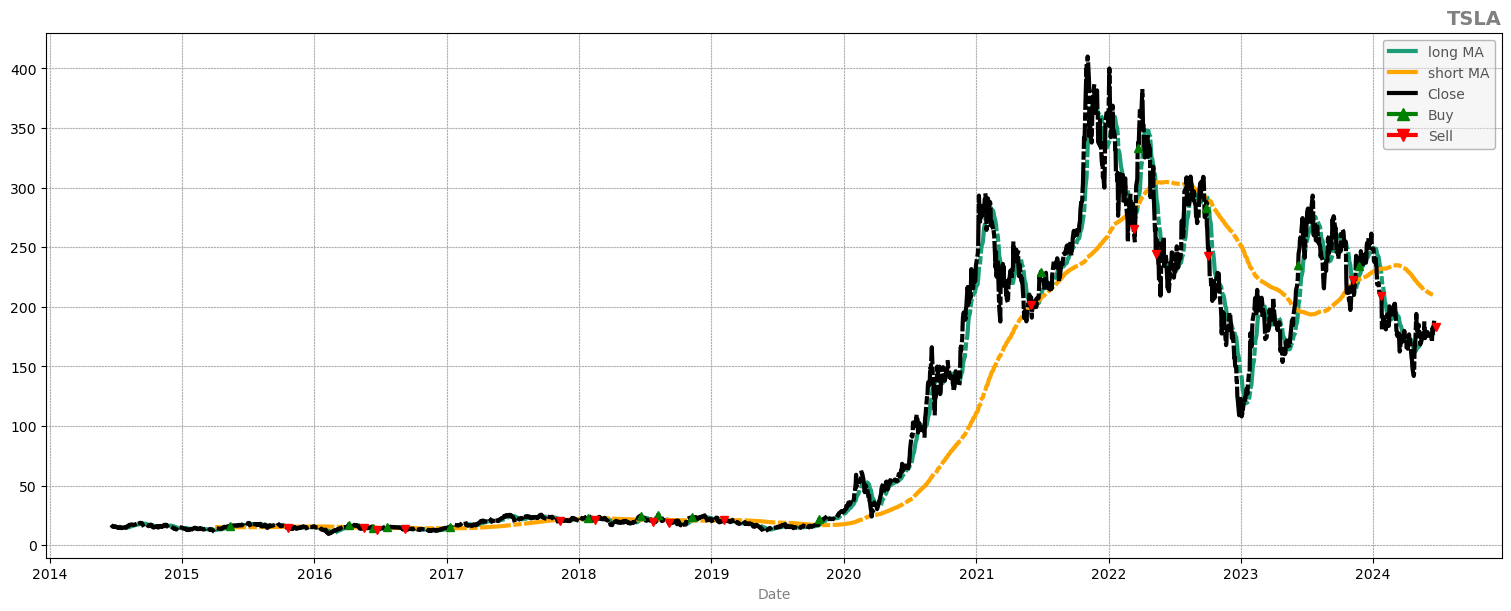

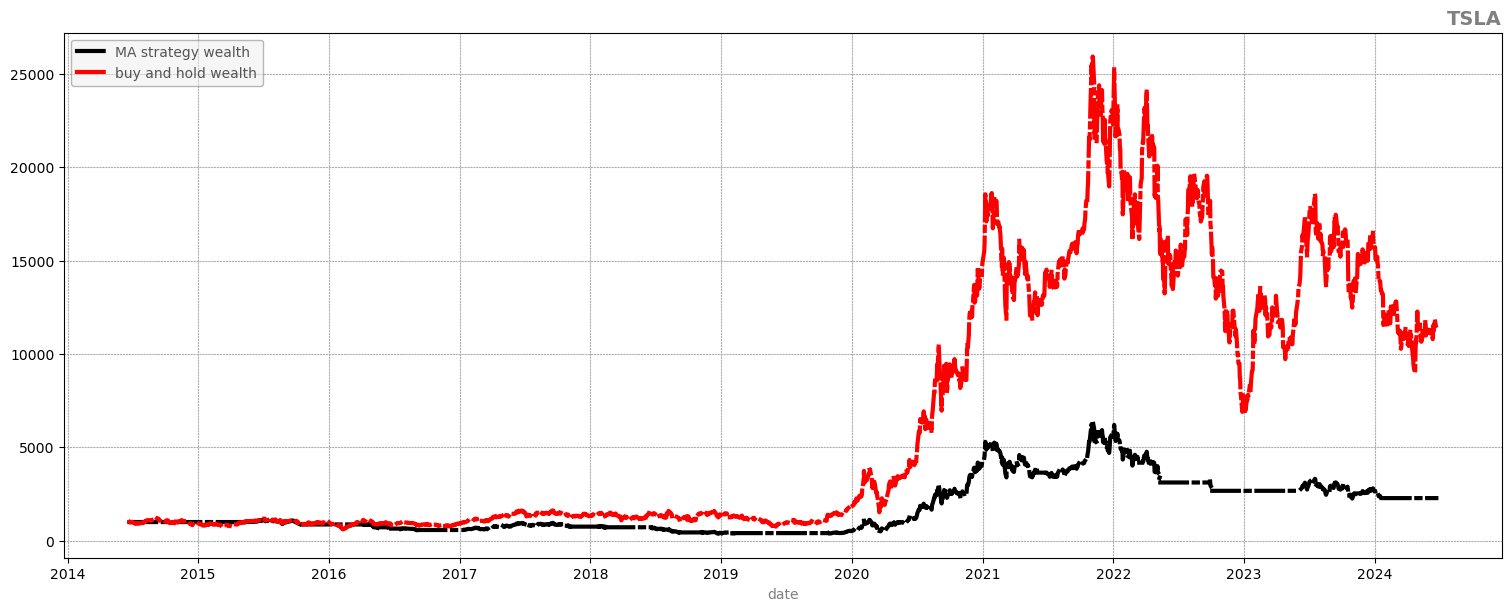

In [9]:
print(stock)

df = get_stock_data(stock,start_date,end_date, interval, period)
df = ma_strategy(df,long_MA,short_MA)
df = buy_sell_signals(df,stock,start_date,end_date)
df = backtest(df,stock,start_date,end_date, initial_wealth)
graph(df,stock)